In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('BBCA.JK.csv', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)

In [3]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-25,960.0,960.0,945.0,960.0,812.997742,19035000
2010-01-26,965.0,970.0,955.0,960.0,812.997742,87990000
2010-01-27,945.0,965.0,945.0,945.0,800.294495,38155000
2010-01-28,975.0,975.0,945.0,975.0,825.700623,33752500
2010-01-29,1000.0,1000.0,955.0,1000.0,846.872559,59592500
...,...,...,...,...,...,...
2021-12-16,7375.0,7400.0,7275.0,7275.0,7275.000000,95171400
2021-12-17,7325.0,7500.0,7300.0,7500.0,7500.000000,107096800
2021-12-20,7350.0,7400.0,7325.0,7375.0,7375.000000,74753000


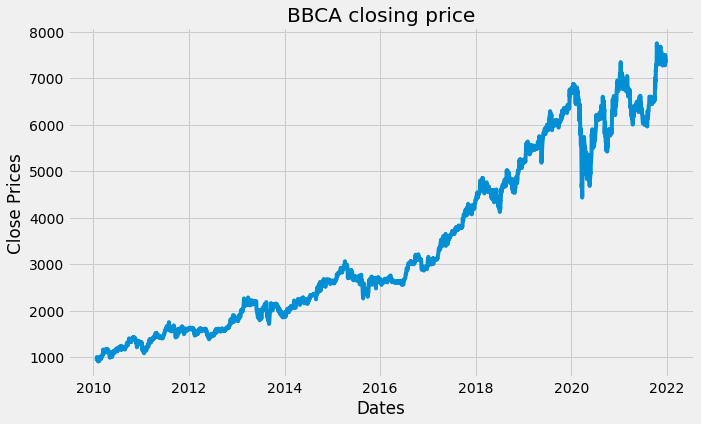

In [4]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(data['Close'])
plt.title('BBCA closing price')
plt.show()

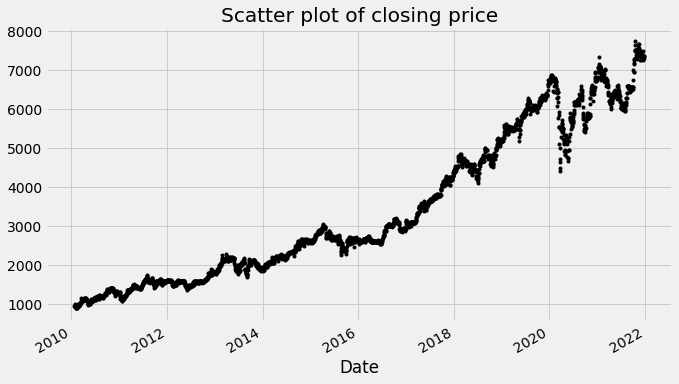

In [5]:
df_close = data['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

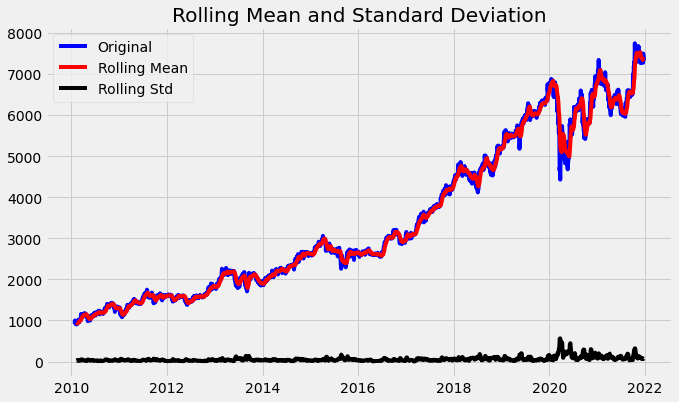

Results of dickey fuller test
Test Statistics                   0.182641
p-value                           0.971271
No. of lags used                 15.000000
Number of observations used    2942.000000
critical value (1%)              -3.432575
critical value (5%)              -2.862523
critical value (10%)             -2.567293
dtype: float64


In [6]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

No handles with labels found to put in legend.


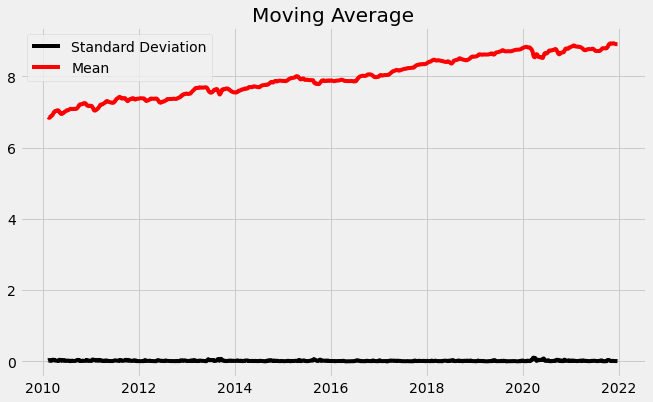

In [7]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

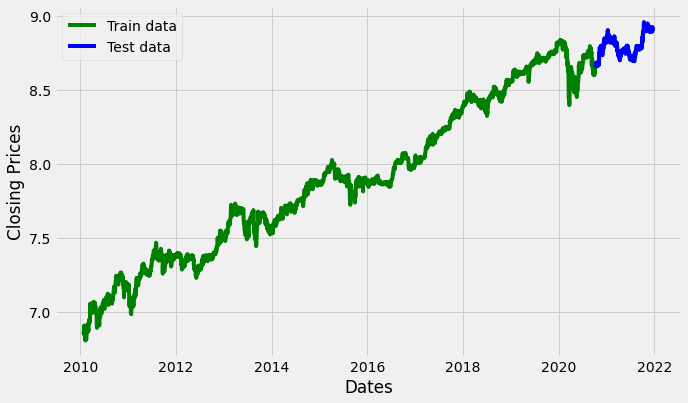

In [8]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [9]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',
                      max_p=3, max_q=3,
                      m=1,          
                      d=None, 
                      seasonal=False,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore', 
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=18549.919, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.64 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-14171.357, Time=1.14 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=1.43 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-14170.291, Time=1.23 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.67 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.77 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-14143.894, Time=1.62 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-14171.385, Time=0.84 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=594.667, Time=0.45 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-14168.544, Time=0.96 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-14170.033, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4136.963,

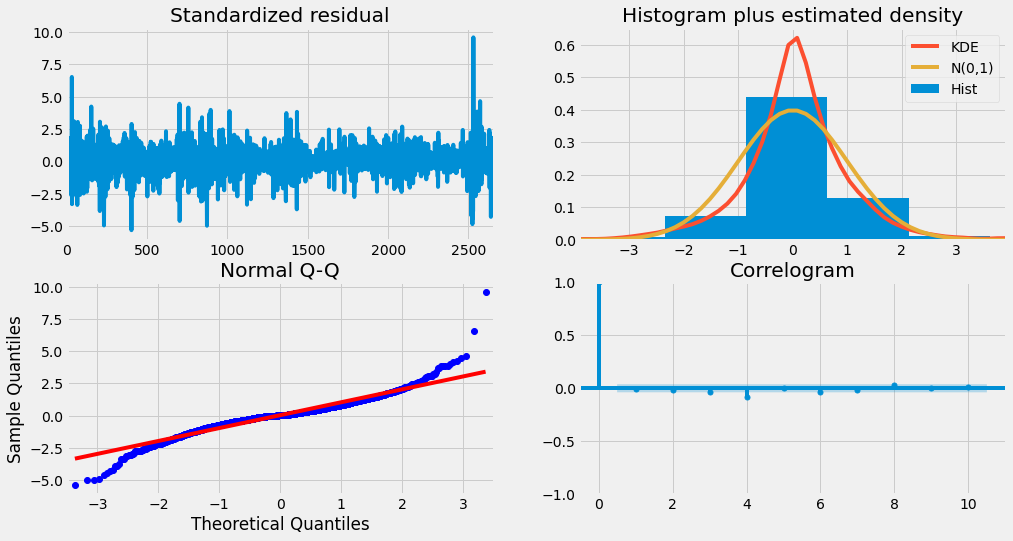

In [10]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [11]:
import statsmodels.tsa.arima.model as stats

model = stats.ARIMA(train_data, order=(3, 1, 2))  
fitted = model.fit()  
print(fitted.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2659
Model:                 ARIMA(3, 1, 2)   Log Likelihood                7097.853
Date:                Thu, 23 Dec 2021   AIC                         -14183.707
Time:                        23:51:12   BIC                         -14148.395
Sample:                             0   HQIC                        -14170.927
                               - 2659                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0488      1.133      0.043      0.966      -2.172       2.269
ar.L2          0.5039      0.795      0.634      0.526      -1.055       2.062
ar.L3          0.0125      0.021      0.601      0.5

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


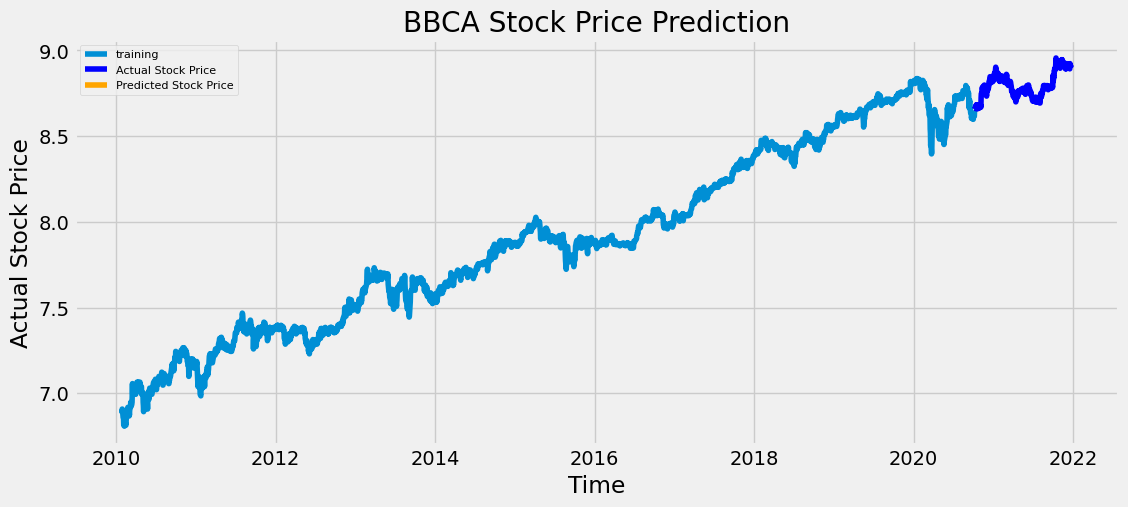

In [12]:

fc = fitted.forecast(544, alpha=0.05)
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(fc, index=test_data.index)
upper_series = pd.Series(fc, index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('BBCA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()